# **3. MODELADO RF Y SVM (PRE-ENTRENAMIENTO DE SL)**

Este notebbok tiene como propósito comparar el rendimiento de dos modelos clásicos de clasificación, Random Forest y SVM, entrenados sobre ventanas temporales generadas por combinación (ubicación + frecuencia).Incluye una etapa de comparación de consumo computacional y experimentos de balanceo
con RandomOverSampler y SMOTE, con el fin de elegir la configuración más adecuada para un sistema basado en Stream Learning.





**3.1 IMPORTACIÓN DE LIBRERIAS**

In [1]:
# Librerías básicas
from google.colab import drive
drive.mount('/content/drive')
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de modelos y evaluación
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Balanceo
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

# Medición de recursos
import time
import psutil
import joblib

Mounted at /content/drive


**3.2 RUTA DE LOS DATASETS**

In [2]:
ruta_base = "/content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/DATASET_ETAPAS_POSTERIORES/"

archivos_grupo = {
    'muñeca - 20hz': os.path.join(ruta_base, 'ventanas_muñeca_20.csv'),
    'muñeca - 50hz': os.path.join(ruta_base, 'ventanas_muñeca_50.csv'),
    'bolsillo - 20hz': os.path.join(ruta_base, 'ventanas_bolsillo_20.csv'),
    'bolsillo - 50hz': os.path.join(ruta_base, 'ventanas_bolsillo_50.csv')
}


In [3]:
ruta_balanceados= "/content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/DATASET_ETAPAS_POSTERIORES/"

archivos_balanceados_random = {
    'muñeca - 20hz': os.path.join(ruta_balanceados, 'ventanas_muñeca_20_balanceado_random.csv'),
    'muñeca - 50hz': os.path.join(ruta_balanceados, 'ventanas_muñeca_50_balanceado_random.csv'),
    'bolsillo - 20hz': os.path.join(ruta_balanceados, 'ventanas_bolsillo_20_balanceado_random.csv'),
    'bolsillo - 50hz': os.path.join(ruta_balanceados, 'ventanas_bolsillo_50_balanceado_random.csv')
}

archivos_balanceados_smote = {
    'muñeca - 20hz': os.path.join(ruta_balanceados, 'ventanas_muñeca_20_balanceado_smote.csv'),
    'muñeca - 50hz': os.path.join(ruta_balanceados, 'ventanas_muñeca_50_balanceado_smote.csv'),
    'bolsillo - 20hz': os.path.join(ruta_balanceados, 'ventanas_bolsillo_20_balanceado_smote.csv'),
    'bolsillo - 50hz': os.path.join(ruta_balanceados, 'ventanas_bolsillo_50_balanceado_smote.csv')
}


**3.3 DEFINICIÓN DE FUNCIONES**

FUNCIÓN PARA CÁLCULAR CONSUMO DE LOS MODELOS

    Evalúa el consumo de recursos del modelo dado:
    - Tiempo promedio de inferencia por muestra
    - Memoria RAM utilizada
    - Tamaño del modelo serializado


In [4]:
def evaluar_consumo_modelo(modelo, X_test, nombre_archivo='modelo'):
    import os, time, joblib, tracemalloc
    import numpy as np

    # Warm-up para evitar costos de inicialización en la medición real
    try:
        _ = modelo.predict(X_test[:1])
    except Exception:
        pass

    n = len(X_test) if hasattr(X_test, '__len__') else 0
    if n == 0:
        print("X_test vacío; no se puede medir.")
        return 0.0, 0.0, 0.0, 0.0, 0.0

    # ---- Tiempo + Memoria (tracemalloc) ----
    tracemalloc.start()
    t0 = time.perf_counter()
    _ = modelo.predict(X_test)
    t1 = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Tiempos
    tiempo_total_s  = (t1 - t0)
    tiempo_total_ms = tiempo_total_s * 1000.0
    tiempo_ms_muestra = (tiempo_total_ms / n)

    # Memoria (heap Python)
    ram_total_bytes = peak  # pico total durante predict
    ram_por_muestra_bytes = ram_total_bytes / n

    # Tamaño del modelo serializado
    joblib.dump(modelo, f"{nombre_archivo}.pkl")
    tamano_modelo_kb = os.path.getsize(f"{nombre_archivo}.pkl") / 1024.0

    # Reporte
    print(f"Evaluación del modelo: {nombre_archivo}")
    print(f"Tiempo TOTAL de inferencia: {tiempo_total_ms:.3f} ms ({tiempo_total_s:.6f} s)")
    print(f"Tiempo PROMEDIO por muestra: {tiempo_ms_muestra:.4f} ms")
    print(f"RAM pico TOTAL en predict: {ram_total_bytes} bytes ({ram_total_bytes/1024:.6f} KB)")
    print(f"RAM pico por muestra: {ram_por_muestra_bytes:.2f} bytes")
    print(f"Tamaño del modelo (.pkl): {tamano_modelo_kb:.2f} KB")

    # Devuelve: tiempos (total, por muestra), RAM (total, por muestra), tamaño
    return tiempo_total_ms, tiempo_ms_muestra, ram_total_bytes, ram_por_muestra_bytes, tamano_modelo_kb


**3.4 EXPLORACIÓN DE SEPARABILIDAD DE CLASES**

Se visualiza la separabilidad de clases en el espacio de características
para evidenciar si hay linealidad o no y definir con que algoritmos es mejor trabajar.

Se usan dos herramientas para la visualización:
1. Scatter 2D con dos features (ax_mean vs az_mean) por cada combinación (muñeca/bolsillo × 20/50).

2. PCA 2D global usando todas las features agregadas (*_mean, *_std, *_min, *_max, *_range) de todas las combinaciones.

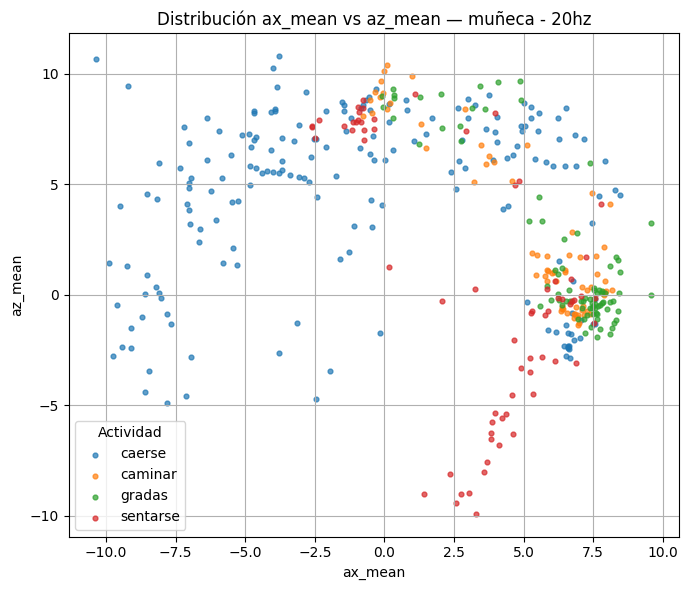

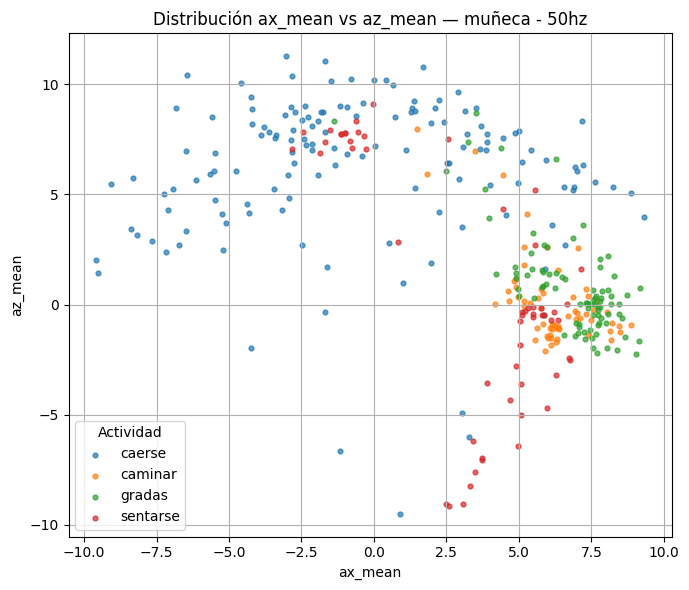

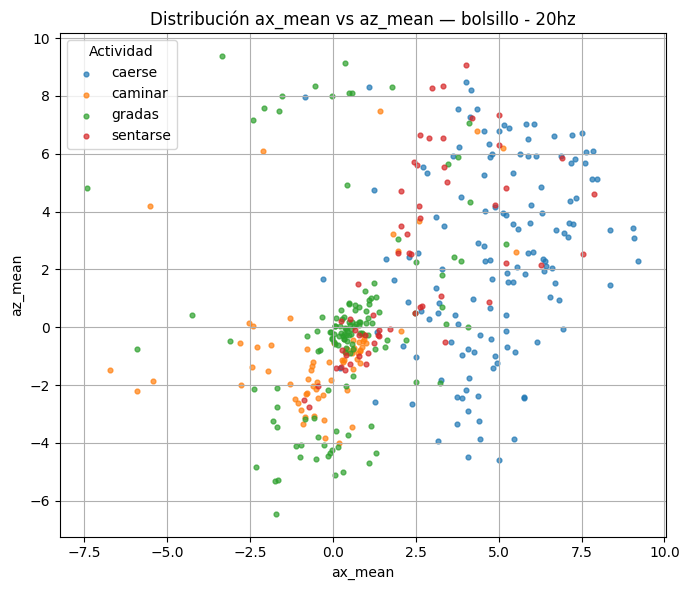

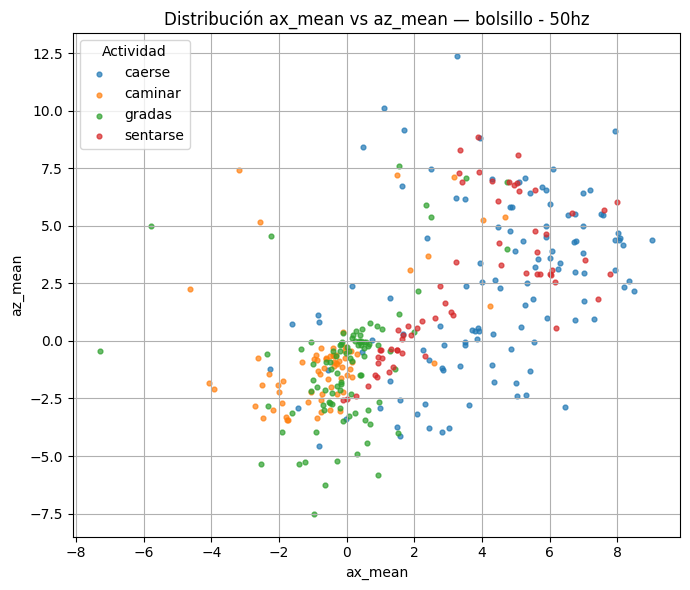

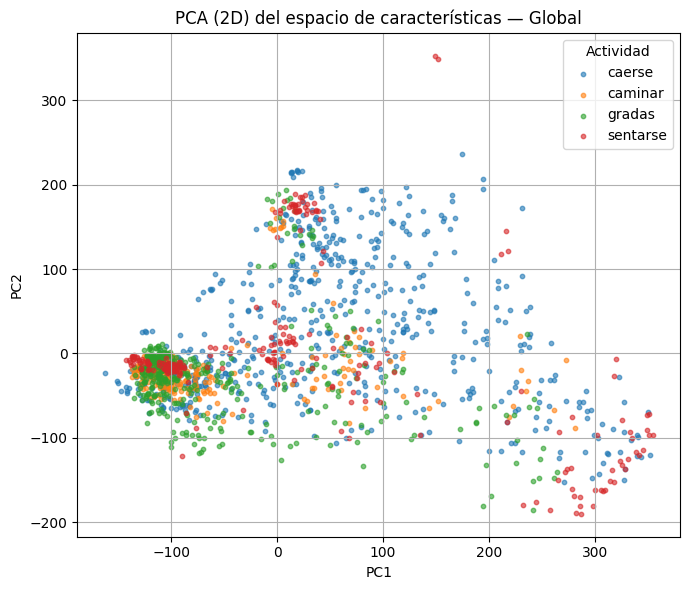

Varianza explicada por PC1 y PC2: [0.61996728 0.24655195]


In [5]:
from sklearn.decomposition import PCA

# === A) Scatter 2D para cada combinación ===
for grupo, ruta in archivos_grupo.items():
    if not os.path.exists(ruta):
        print(f"[Aviso] No existe: {ruta}")
        continue

    df = pd.read_csv(ruta)

    # Elegir dos features (ax_mean y az_mean)
    x_var, y_var = 'ax_mean', 'az_mean'
    if x_var not in df.columns or y_var not in df.columns:
        cand = [c for c in df.columns if c.endswith('_mean')]
        if len(cand) >= 2:
            x_var, y_var = cand[0], cand[1]
        else:
            print(f"[Aviso] {grupo}: no hay columnas *_mean suficientes.")
            continue

    # Scatter por clases
    plt.figure(figsize=(7, 6))
    for cls in df['etiqueta'].unique():
        m = df['etiqueta'] == cls
        plt.scatter(df.loc[m, x_var], df.loc[m, y_var], s=12, alpha=0.7, label=cls)
    plt.title(f"Distribución {x_var} vs {y_var} — {grupo}")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.legend(title="Actividad")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === B) PCA 2D global (todas las combinaciones) ===
df_all = pd.concat(
    [pd.read_csv(p) for p in archivos_grupo.values() if os.path.exists(p)],
    ignore_index=True
)

# Seleccionar todas las columnas de características numéricas
feat_cols = [c for c in df_all.columns if any(s in c for s in ['_mean', '_std', '_min', '_max', '_range'])]
X = df_all[feat_cols].fillna(0).values
y = df_all['etiqueta'].values

# Aplicar PCA
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X)

# Graficar PCA global
plt.figure(figsize=(7, 6))
for cls in pd.unique(y):
    m = (y == cls)
    plt.scatter(Z[m, 0], Z[m, 1], s=10, alpha=0.6, label=cls)
plt.title("PCA (2D) del espacio de características — Global")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Actividad")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Varianza explicada por PC1 y PC2:", pca.explained_variance_ratio_)


**3.5 MODELADO Y EVALUACIÓN DE RANDOM FOREST Y SVM SIN BALANCEAR**

MODELADO 1 --> Random Forest sin Balancear

Evaluando grupo: muñeca - 20hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR/rf_modelo_muñeca__20hz
Tiempo TOTAL de inferencia: 41.340 ms (0.041340 s)
Tiempo PROMEDIO por muestra: 0.3334 ms
RAM pico TOTAL en predict: 47947 bytes (46.823242 KB)
RAM pico por muestra: 386.67 bytes
Tamaño del modelo (.pkl): 899.57 KB
              precision    recall  f1-score   support

      caerse       0.83      0.95      0.89        57
     caminar       0.74      0.67      0.70        21
      gradas       0.88      0.81      0.84        26
    sentarse       0.75      0.60      0.67        20

    accuracy                           0.81       124
   macro avg       0.80      0.76      0.77       124
weighted avg       0.81      0.81      0.81       124



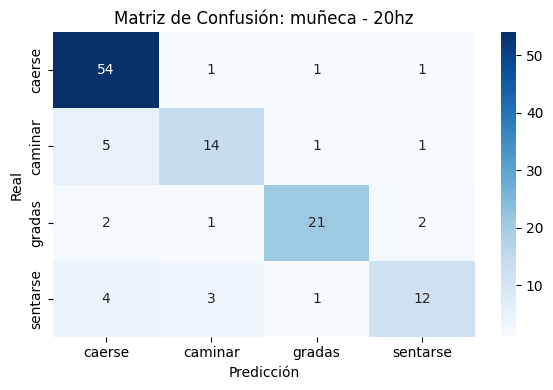

Evaluando grupo: muñeca - 50hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR/rf_modelo_muñeca__50hz
Tiempo TOTAL de inferencia: 40.191 ms (0.040191 s)
Tiempo PROMEDIO por muestra: 0.3865 ms
RAM pico TOTAL en predict: 40747 bytes (39.791992 KB)
RAM pico por muestra: 391.80 bytes
Tamaño del modelo (.pkl): 585.88 KB
              precision    recall  f1-score   support

      caerse       0.82      0.95      0.88        42
     caminar       0.94      0.84      0.89        19
      gradas       0.92      0.88      0.90        26
    sentarse       0.85      0.65      0.73        17

    accuracy                           0.87       104
   macro avg       0.88      0.83      0.85       104
weighted avg       0.87      0.87      0.86       104



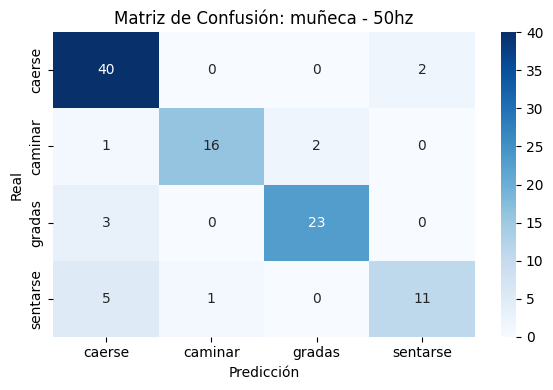

Evaluando grupo: bolsillo - 20hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR/rf_modelo_bolsillo__20hz
Tiempo TOTAL de inferencia: 41.940 ms (0.041940 s)
Tiempo PROMEDIO por muestra: 0.3495 ms
RAM pico TOTAL en predict: 46507 bytes (45.416992 KB)
RAM pico por muestra: 387.56 bytes
Tamaño del modelo (.pkl): 857.20 KB
              precision    recall  f1-score   support

      caerse       0.91      0.95      0.93        41
     caminar       0.92      0.52      0.67        21
      gradas       0.76      0.88      0.81        40
    sentarse       0.79      0.83      0.81        18

    accuracy                           0.83       120
   macro avg       0.84      0.80      0.81       120
weighted avg       0.84      0.83      0.83       120



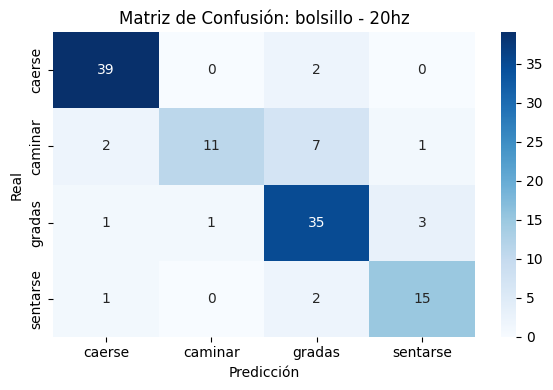

Evaluando grupo: bolsillo - 50hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR/rf_modelo_bolsillo__50hz
Tiempo TOTAL de inferencia: 47.827 ms (0.047827 s)
Tiempo PROMEDIO por muestra: 0.4643 ms
RAM pico TOTAL en predict: 40387 bytes (39.440430 KB)
RAM pico por muestra: 392.11 bytes
Tamaño del modelo (.pkl): 762.88 KB
              precision    recall  f1-score   support

      caerse       0.80      0.91      0.85        35
     caminar       0.93      0.62      0.74        21
      gradas       0.73      0.86      0.79        28
    sentarse       0.94      0.79      0.86        19

    accuracy                           0.82       103
   macro avg       0.85      0.79      0.81       103
weighted avg       0.83      0.82      0.81       103



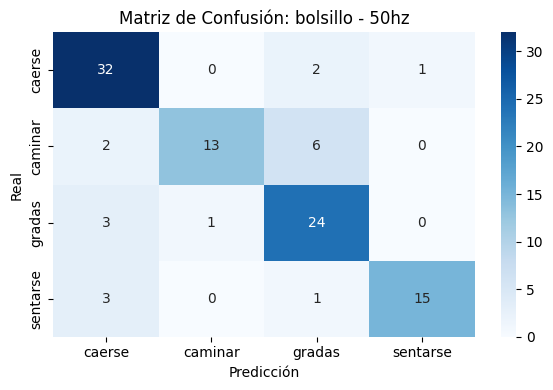

Consumo de recursos Random Forest:
             Grupo  Accuracy  Macro_F1   F1_Caer  F1_Caminar  F1_Escaleras  \
0    muñeca - 20hz  0.814516  0.772978  0.885246    0.700000      0.840000   
1    muñeca - 50hz  0.865385  0.850826  0.879121    0.888889      0.901961   
2  bolsillo - 20hz  0.833333  0.805001  0.928571    0.666667      0.813953   
3  bolsillo - 50hz  0.815534  0.810055  0.853333    0.742857      0.786885   

   F1_Sentarse-Pararse  Tiempo total (ms)  Tiempo por muestra (ms)  \
0             0.666667             41.340                   0.3334   
1             0.733333             40.191                   0.3865   
2             0.810811             41.940                   0.3495   
3             0.857143             47.827                   0.4643   

   RAM total (bytes)  RAM por muestra (bytes)  Tamaño modelo (KB)  
0              47947                   386.67              899.57  
1              40747                   391.80              585.88  
2              4650

In [6]:
# Lista para guardar resultados de consumo
resultados_rf = []

# Iterar por grupo

# Iterar por grupo
for grupo, archivo in archivos_grupo.items():
    print(f"Evaluando grupo: {grupo}")
    df = pd.read_csv(archivo)

    # Separar features y etiquetas
    X = df.drop(columns=['etiqueta', 'start_index', 'end_index', 'n_muestras'], errors='ignore')
    y = df['etiqueta']

    # Dividir dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    # Entrenar modelo
    clf_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)

    # Ruta donde se guardarán los .PKL
    carpeta_modelos_sin_balanceo_rf = "/content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR"
    os.makedirs(carpeta_modelos_sin_balanceo_rf, exist_ok=True)

    # Evaluar consumo de recursos por grupo
    nombre_archivo = os.path.join(carpeta_modelos_sin_balanceo_rf, f"rf_modelo_{grupo.replace(' ', '_').replace('-', '')}")
    tiempo_total_ms, tiempo_ms, ram_total_bytes, ram_muestra_bytes, tam_modelo_kb = evaluar_consumo_modelo(clf_rf, X_test, nombre_archivo=nombre_archivo)

    # Guardar resultados
    report = classification_report(y_test, y_pred, output_dict=True)


    resultados_rf.append({
        'Grupo': grupo,
        'Accuracy': report['accuracy'],
        'Macro_F1': report['macro avg']['f1-score'],
        'F1_Caer': report.get('caerse', {}).get('f1-score', 0),
        'F1_Caminar': report.get('caminar', {}).get('f1-score', 0),
        'F1_Escaleras': report.get('gradas', {}).get('f1-score', 0),
        'F1_Sentarse-Pararse': report.get('sentarse', {}).get('f1-score', 0),
        'Tiempo total (ms)': round(tiempo_total_ms, 3),
        'Tiempo por muestra (ms)': round(tiempo_ms, 4),
        'RAM total (bytes)': int(ram_total_bytes),
        'RAM por muestra (bytes)': round(ram_muestra_bytes, 2),
        'Tamaño modelo (KB)': round(tam_modelo_kb, 2)
    })

    # Reporte de clasificación
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=clf_rf.classes_)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clf_rf.classes_, yticklabels=clf_rf.classes_)
    plt.title(f'Matriz de Confusión: {grupo}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

# Convertir resultados a DataFrame
df_resultados_rf = pd.DataFrame(resultados_rf)
print("Consumo de recursos Random Forest:")
print(df_resultados_rf)


MODELO 2--> SVM sin Balancear

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR/svm_modelo_muñeca__20hz
Tiempo TOTAL de inferencia: 3.600 ms (0.003600 s)
Tiempo PROMEDIO por muestra: 0.0290 ms
RAM pico TOTAL en predict: 46824 bytes (45.726562 KB)
RAM pico por muestra: 377.61 bytes
Tamaño del modelo (.pkl): 81.95 KB
Reporte para grupo: muñeca - 20hz
              precision    recall  f1-score   support

      caerse       0.88      0.91      0.90        57
     caminar       0.80      0.76      0.78        21
      gradas       0.75      0.81      0.78        26
    sentarse       0.71      0.60      0.65        20

    accuracy                           0.81       124
   macro avg       0.78      0.77      0.78       124
weighted avg       0.81      0.81      0.81       124



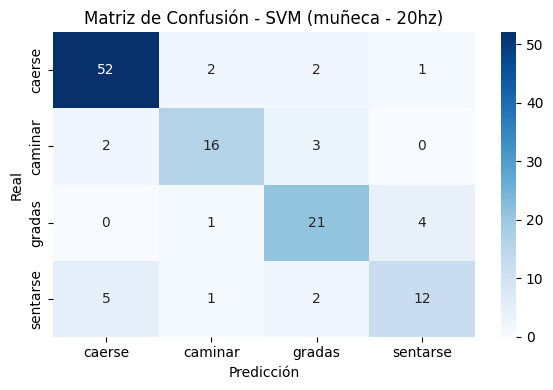

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR/svm_modelo_muñeca__50hz
Tiempo TOTAL de inferencia: 2.717 ms (0.002717 s)
Tiempo PROMEDIO por muestra: 0.0261 ms
RAM pico TOTAL en predict: 39624 bytes (38.695312 KB)
RAM pico por muestra: 381.00 bytes
Tamaño del modelo (.pkl): 59.83 KB
Reporte para grupo: muñeca - 50hz
              precision    recall  f1-score   support

      caerse       0.89      0.95      0.92        42
     caminar       0.85      0.89      0.87        19
      gradas       1.00      0.81      0.89        26
    sentarse       0.83      0.88      0.86        17

    accuracy                           0.89       104
   macro avg       0.89      0.88      0.89       104
weighted avg       0.90      0.89      0.89       104



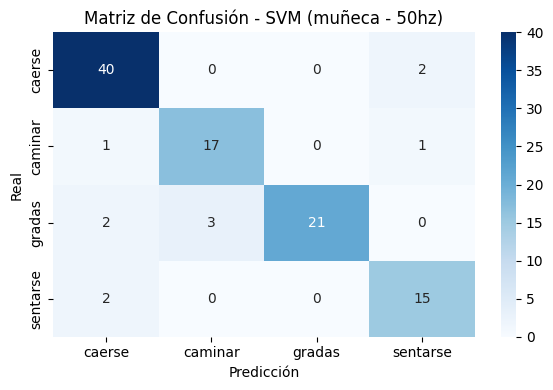

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR/svm_modelo_bolsillo__20hz
Tiempo TOTAL de inferencia: 3.362 ms (0.003362 s)
Tiempo PROMEDIO por muestra: 0.0280 ms
RAM pico TOTAL en predict: 45384 bytes (44.320312 KB)
RAM pico por muestra: 378.20 bytes
Tamaño del modelo (.pkl): 71.47 KB
Reporte para grupo: bolsillo - 20hz
              precision    recall  f1-score   support

      caerse       0.92      0.88      0.90        41
     caminar       0.80      0.57      0.67        21
      gradas       0.84      0.93      0.88        40
    sentarse       0.68      0.83      0.75        18

    accuracy                           0.83       120
   macro avg       0.81      0.80      0.80       120
weighted avg       0.84      0.83      0.83       120



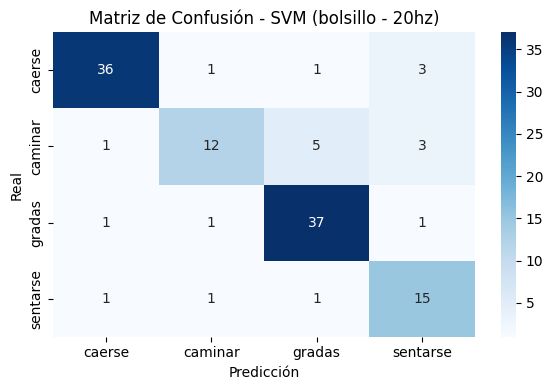

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR/svm_modelo_bolsillo__50hz
Tiempo TOTAL de inferencia: 4.713 ms (0.004713 s)
Tiempo PROMEDIO por muestra: 0.0458 ms
RAM pico TOTAL en predict: 39264 bytes (38.343750 KB)
RAM pico por muestra: 381.20 bytes
Tamaño del modelo (.pkl): 71.50 KB
Reporte para grupo: bolsillo - 50hz
              precision    recall  f1-score   support

      caerse       0.89      0.89      0.89        35
     caminar       0.82      0.67      0.74        21
      gradas       0.74      0.82      0.78        28
    sentarse       0.85      0.89      0.87        19

    accuracy                           0.83       103
   macro avg       0.83      0.82      0.82       103
weighted avg       0.83      0.83      0.82       103



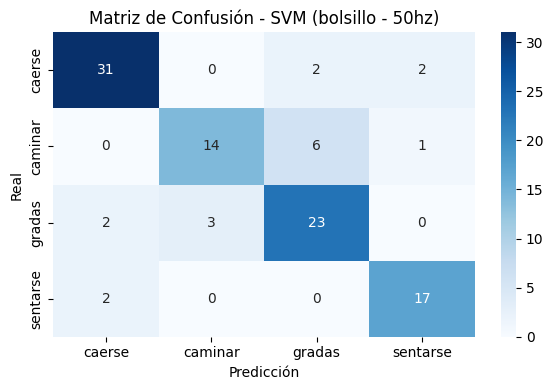

 Resultados resumidos SVM:
             Grupo  Accuracy  Macro_F1   F1_Caer  F1_Caminar  F1_Escaleras  \
0    muñeca - 20hz  0.814516  0.775866  0.896552    0.780488      0.777778   
1    muñeca - 50hz  0.894231  0.885524  0.919540    0.871795      0.893617   
2  bolsillo - 20hz  0.833333  0.799405  0.900000    0.666667      0.880952   
3  bolsillo - 50hz  0.825243  0.818503  0.885714    0.736842      0.779661   

   F1_Sentarse-Pararse  Tiempo total (ms)  Tiempo por muestra (ms)  \
0             0.648649              3.600                   0.0290   
1             0.857143              2.717                   0.0261   
2             0.750000              3.362                   0.0280   
3             0.871795              4.713                   0.0458   

   RAM total (bytes)  RAM por muestra (bytes)  Tamaño modelo (KB)  
0              46824                   377.61               81.95  
1              39624                   381.00               59.83  
2              45384       

In [7]:
# Lista para guardar resultados
resultados_svm = []

for grupo, archivo in archivos_grupo.items():
    try:
        df = pd.read_csv(archivo)

        # Separar features y etiquetas
        X = df.drop(columns=['etiqueta', 'start_index', 'end_index', 'n_muestras'], errors='ignore')
        y = df['etiqueta']

        # Escalado de características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)

        # GridSearch para SVM
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.01, 0.1, 1]
        }

        grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=42),
                            param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train, y_train)
        modelo_svm = grid.best_estimator_

        # Predicción
        y_pred = modelo_svm.predict(X_test)

        # Ruta donde se guardarán los .PKL
        carpeta_modelos_sin_balanceo_svm = "/content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_SIN_BALANCEAR"
        os.makedirs(carpeta_modelos_sin_balanceo_svm, exist_ok=True)

        # Evaluar consumo
        nombre_archivo = os.path.join(carpeta_modelos_sin_balanceo_svm, f"svm_modelo_{grupo.replace(' ', '_').replace('-', '')}")
        tiempo_total_ms, tiempo_ms, ram_total_bytes, ram_muestra_bytes, tam_modelo_kb = evaluar_consumo_modelo(modelo_svm, X_test, nombre_archivo=nombre_archivo)

        # Reporte de métricas
        report = classification_report(y_test, y_pred, output_dict=True)
        print(f"Reporte para grupo: {grupo}")
        print(classification_report(y_test, y_pred))

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred, labels=modelo_svm.classes_)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=modelo_svm.classes_, yticklabels=modelo_svm.classes_)
        plt.title(f'Matriz de Confusión - SVM ({grupo})')
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.tight_layout()
        plt.show()

        # Guardar métricas y consumo
        resultados_svm.append({
            'Grupo': grupo,
            'Accuracy': report['accuracy'],
            'Macro_F1': report['macro avg']['f1-score'],
            'F1_Caer': report.get('caerse', {}).get('f1-score', 0),
            'F1_Caminar': report.get('caminar', {}).get('f1-score', 0),
            'F1_Escaleras': report.get('gradas', {}).get('f1-score', 0),
            'F1_Sentarse-Pararse': report.get('sentarse', {}).get('f1-score', 0),
            'Tiempo total (ms)': round(tiempo_total_ms, 3),
            'Tiempo por muestra (ms)': round(tiempo_ms, 4),
            'RAM total (bytes)': int(ram_total_bytes),
            'RAM por muestra (bytes)': round(ram_muestra_bytes, 2),
            'Tamaño modelo (KB)': round(tam_modelo_kb, 2)
        })

    except Exception as e:
        print(f"Error con el grupo {grupo}: {e}")
        resultados_svm.append({'Grupo': grupo, 'Error': str(e)})

# Mostrar resultados
df_resultados_svm = pd.DataFrame(resultados_svm)
print(" Resultados resumidos SVM:")
print(df_resultados_svm)


**3.6 APLICACIÓN DE TÉCNICAS DE BALANCEO**

1. RandomOverSampler:  es una técnica de balanceo que consiste en duplicar aleatoriamente muestras de las clases minoritarias hasta igualar la cantidad de ejemplos de la clase mayoritaria. Aunque no genera nueva información, es útil para corregir desbalances en datasets pequeños de forma simple, permitiendo que el modelo aprenda de forma equitativa sin introducir sesgos por frecuencia de clase.

In [8]:
# Diccionario para guardar las distribuciones antes y después
distribuciones = {}

# Procesar cada archivo
for grupo, nombre_archivo in archivos_grupo.items():
    path = os.path.join(ruta_base, nombre_archivo)
    df = pd.read_csv(path)

    # Separar features y etiquetas
    X = df.drop(columns=['etiqueta', 'start_index', 'end_index', 'n_muestras'], errors='ignore')
    y = df['etiqueta']

    # Aplicar RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Guardar distribuciones
    distribuciones[grupo] = {
        'original': dict(Counter(y)),
        'balanceado': dict(Counter(y_resampled))
    }

    # Combinar DataFrame balanceado
    df_balanceado_random = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='etiqueta')], axis=1)

    # Guardar archivo
    balanceado_path = os.path.join(ruta_base, nombre_archivo.replace('.csv', '_balanceado_random.csv'))
    df_balanceado_random.to_csv(balanceado_path, index=False)

df_distribuciones_random = pd.DataFrame.from_dict(distribuciones, orient='index')
print("Distribución de clases balanceadas:")
print(df_distribuciones_random)

Distribución de clases balanceadas:
                                                          original  \
muñeca - 20hz    {'caerse': 188, 'caminar': 70, 'gradas': 85, '...   
muñeca - 50hz    {'caerse': 140, 'caminar': 63, 'gradas': 87, '...   
bolsillo - 20hz  {'caerse': 136, 'caminar': 71, 'gradas': 133, ...   
bolsillo - 50hz  {'caerse': 116, 'caminar': 70, 'gradas': 94, '...   

                                                        balanceado  
muñeca - 20hz    {'caerse': 188, 'caminar': 188, 'gradas': 188,...  
muñeca - 50hz    {'caerse': 140, 'caminar': 140, 'gradas': 140,...  
bolsillo - 20hz  {'caerse': 136, 'caminar': 136, 'gradas': 136,...  
bolsillo - 50hz  {'caerse': 116, 'caminar': 116, 'gradas': 116,...  


2. SMOTE: es una técnica más avanzada que crea nuevas muestras sintéticas de las clases minoritarias, interpolando entre instancias existentes. Esto permite aumentar la diversidad del conjunto de entrenamiento sin duplicar datos, ayudando al modelo a generalizar mejor y a reducir el riesgo de sobreajuste que podría ocurrir con el sobremuestreo aleatorio.

In [9]:
# Diccionario para guardar conteos
distribuciones_smote = {}

for grupo, archivo in archivos_grupo.items():
    path = os.path.join(ruta_base, archivo)
    df = pd.read_csv(path)

    # Separar características y etiquetas
    X = df.drop(columns=['etiqueta', 'start_index', 'end_index', 'n_muestras'], errors='ignore')
    y = df['etiqueta']

    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # Guardar conteos antes y después
    distribuciones_smote[grupo] = {
        'original': dict(Counter(y)),
        'balanceado': dict(Counter(y_res))
    }

    # Guardar archivo CSV balanceado con sufijo _smote
    df_res = pd.DataFrame(X_res, columns=X.columns)
    df_res['etiqueta'] = y_res
    nombre_archivo = archivo.replace('.csv', '_balanceado_smote.csv')
    df_res.to_csv(os.path.join(ruta_base, nombre_archivo), index=False)

# Mostrar resultados
df_distribuciones_smote = pd.DataFrame.from_dict(distribuciones_smote, orient='index')
print("Distribución de clases balanceadas con SMOTE:")
print(df_distribuciones_smote)


Distribución de clases balanceadas con SMOTE:
                                                          original  \
muñeca - 20hz    {'caerse': 188, 'caminar': 70, 'gradas': 85, '...   
muñeca - 50hz    {'caerse': 140, 'caminar': 63, 'gradas': 87, '...   
bolsillo - 20hz  {'caerse': 136, 'caminar': 71, 'gradas': 133, ...   
bolsillo - 50hz  {'caerse': 116, 'caminar': 70, 'gradas': 94, '...   

                                                        balanceado  
muñeca - 20hz    {'caerse': 188, 'caminar': 188, 'gradas': 188,...  
muñeca - 50hz    {'caerse': 140, 'caminar': 140, 'gradas': 140,...  
bolsillo - 20hz  {'caerse': 136, 'caminar': 136, 'gradas': 136,...  
bolsillo - 50hz  {'caerse': 116, 'caminar': 116, 'gradas': 116,...  


**3.7 MODELADO Y EVALUACIÓN CON DATOS BALANCEADOS**

MODELO 3 --> RF Balanceado con RandomOverSampler

Evaluando grupo: muñeca - 20hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/rf_modelo_random_muñeca__20hz
Tiempo TOTAL de inferencia: 78.135 ms (0.078135 s)
Tiempo PROMEDIO por muestra: 0.3457 ms
RAM pico TOTAL en predict: 76755 bytes (74.956055 KB)
RAM pico por muestra: 339.62 bytes
Tamaño del modelo (.pkl): 1198.07 KB
              precision    recall  f1-score   support

      caerse       1.00      0.91      0.95        57
     caminar       0.96      0.96      0.96        56
      gradas       0.93      0.98      0.96        57
    sentarse       0.97      1.00      0.98        56

    accuracy                           0.96       226
   macro avg       0.97      0.96      0.96       226
weighted avg       0.97      0.96      0.96       226



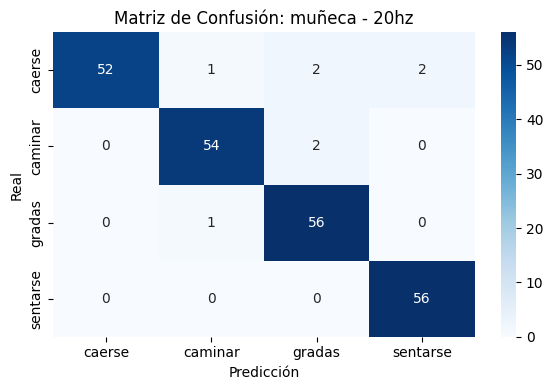

Evaluando grupo: muñeca - 50hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/rf_modelo_random_muñeca__50hz
Tiempo TOTAL de inferencia: 37.424 ms (0.037424 s)
Tiempo PROMEDIO por muestra: 0.2228 ms
RAM pico TOTAL en predict: 63787 bytes (62.291992 KB)
RAM pico por muestra: 379.68 bytes
Tamaño del modelo (.pkl): 699.13 KB
              precision    recall  f1-score   support

      caerse       0.89      0.93      0.91        42
     caminar       0.97      0.90      0.94        42
      gradas       0.97      0.93      0.95        42
    sentarse       0.93      1.00      0.97        42

    accuracy                           0.94       168
   macro avg       0.94      0.94      0.94       168
weighted avg       0.94      0.94      0.94       168



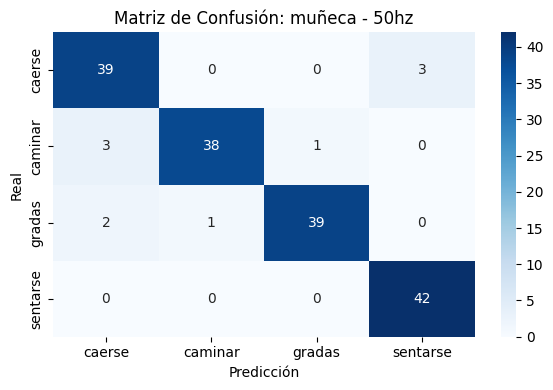

Evaluando grupo: bolsillo - 20hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/rf_modelo_random_bolsillo__20hz
Tiempo TOTAL de inferencia: 38.881 ms (0.038881 s)
Tiempo PROMEDIO por muestra: 0.2371 ms
RAM pico TOTAL en predict: 62347 bytes (60.885742 KB)
RAM pico por muestra: 380.16 bytes
Tamaño del modelo (.pkl): 923.76 KB
              precision    recall  f1-score   support

      caerse       0.95      0.95      0.95        41
     caminar       0.95      0.88      0.91        41
      gradas       0.89      0.95      0.92        41
    sentarse       0.95      0.95      0.95        41

    accuracy                           0.93       164
   macro avg       0.93      0.93      0.93       164
weighted avg       0.93      0.93      0.93       164



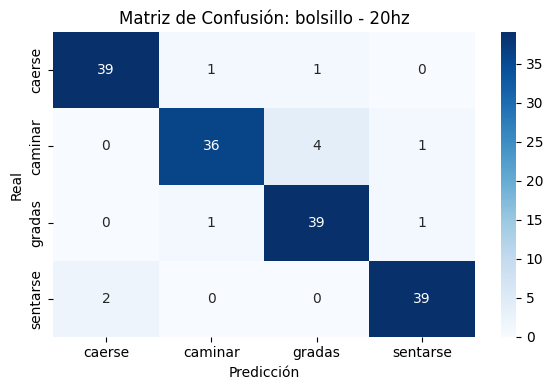

Evaluando grupo: bolsillo - 50hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/rf_modelo_random_bolsillo__50hz
Tiempo TOTAL de inferencia: 42.212 ms (0.042212 s)
Tiempo PROMEDIO por muestra: 0.3015 ms
RAM pico TOTAL en predict: 53707 bytes (52.448242 KB)
RAM pico por muestra: 383.62 bytes
Tamaño del modelo (.pkl): 835.26 KB
              precision    recall  f1-score   support

      caerse       0.91      0.86      0.88        35
     caminar       0.94      0.94      0.94        35
      gradas       0.89      0.91      0.90        35
    sentarse       0.92      0.94      0.93        35

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



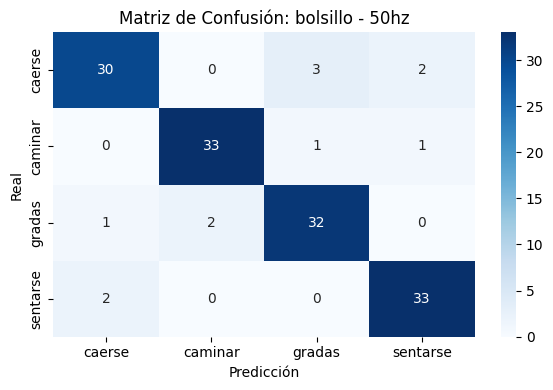

Consumo de recursos Random Forest Balanceado con ROS :
             Grupo  Accuracy  Macro_F1   F1_Caer  F1_Caminar  F1_Escaleras  \
0    muñeca - 20hz  0.964602  0.964534  0.954128    0.964286      0.957265   
1    muñeca - 50hz  0.940476  0.940496  0.906977    0.938272      0.951220   
2  bolsillo - 20hz  0.932927  0.932870  0.951220    0.911392      0.917647   
3  bolsillo - 50hz  0.914286  0.914049  0.882353    0.942857      0.901408   

   F1_Sentarse-Pararse  Tiempo total (ms)  Tiempo por muestra (ms)  \
0             0.982456             78.135                   0.3457   
1             0.965517             37.424                   0.2228   
2             0.951220             38.881                   0.2371   
3             0.929577             42.212                   0.3015   

   RAM total (bytes)  RAM por muestra (bytes)  Tamaño modelo (KB)  
0              76755                   339.62             1198.07  
1              63787                   379.68              699.13  

In [10]:
# Lista para guardar resultados de consumo
resultados_rf_random = []

# Iterar por grupo

# Iterar por grupo
for grupo, archivo in archivos_balanceados_random.items():
    print(f"Evaluando grupo: {grupo}")
    df = pd.read_csv(archivo)

    # Separar features y etiquetas
    X = df.drop(columns=['etiqueta', 'start_index', 'end_index', 'n_muestras'], errors='ignore')
    y = df['etiqueta']

    # Dividir dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    # Entrenar modelo
    clf_rf_random = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf_rf_random.fit(X_train, y_train)
    y_pred = clf_rf_random.predict(X_test)

    # Ruta donde se guardarán los .PKL
    carpeta_modelos_balanceo_rf_random = "/content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS"
    os.makedirs(carpeta_modelos_balanceo_rf_random , exist_ok=True)

    # Evaluar consumo
    nombre_archivo = os.path.join(carpeta_modelos_balanceo_rf_random , f"rf_modelo_random_{grupo.replace(' ', '_').replace('-', '')}")
    tiempo_total_ms, tiempo_ms, ram_total_bytes, ram_muestra_bytes, tam_modelo_kb = evaluar_consumo_modelo(clf_rf_random, X_test, nombre_archivo=nombre_archivo)


    # Guardar resultados
    report = classification_report(y_test, y_pred, output_dict=True)
    resultados_rf_random.append({
        'Grupo': grupo,
        'Accuracy': report['accuracy'],
        'Macro_F1': report['macro avg']['f1-score'],
        'F1_Caer': report.get('caerse', {}).get('f1-score', 0),
        'F1_Caminar': report.get('caminar', {}).get('f1-score', 0),
        'F1_Escaleras': report.get('gradas', {}).get('f1-score', 0),
        'F1_Sentarse-Pararse': report.get('sentarse', {}).get('f1-score', 0),
        'Tiempo total (ms)': round(tiempo_total_ms, 3),
        'Tiempo por muestra (ms)': round(tiempo_ms, 4),
        'RAM total (bytes)': int(ram_total_bytes),
        'RAM por muestra (bytes)': round(ram_muestra_bytes, 2),
        'Tamaño modelo (KB)': round(tam_modelo_kb, 2)
    })

    # Reporte de clasificación
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=clf_rf_random.classes_)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clf_rf_random.classes_, yticklabels=clf_rf_random.classes_)
    plt.title(f'Matriz de Confusión: {grupo}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

# Convertir resultados a DataFrame
df_resultados_rf_random = pd.DataFrame(resultados_rf_random)
print("Consumo de recursos Random Forest Balanceado con ROS :")
print(df_resultados_rf_random)


MODELO 4 --> RF Balanceado con SMOTE

Evaluando grupo: muñeca - 20hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/rf_modelo_smote_muñeca__20hz
Tiempo TOTAL de inferencia: 39.765 ms (0.039765 s)
Tiempo PROMEDIO por muestra: 0.1760 ms
RAM pico TOTAL en predict: 76755 bytes (74.956055 KB)
RAM pico por muestra: 339.62 bytes
Tamaño del modelo (.pkl): 1237.82 KB
              precision    recall  f1-score   support

      caerse       0.90      0.91      0.90        57
     caminar       0.90      0.96      0.93        56
      gradas       1.00      0.88      0.93        57
    sentarse       0.91      0.95      0.93        56

    accuracy                           0.92       226
   macro avg       0.93      0.93      0.92       226
weighted avg       0.93      0.92      0.92       226



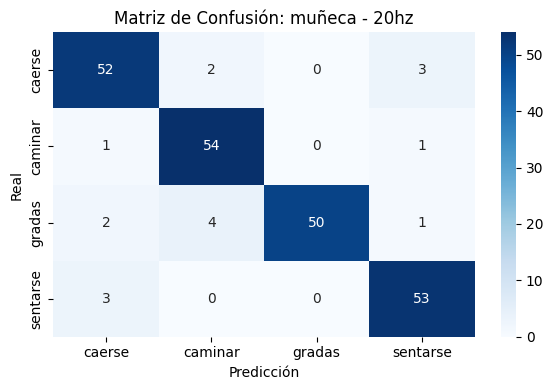

Evaluando grupo: muñeca - 50hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/rf_modelo_smote_muñeca__50hz
Tiempo TOTAL de inferencia: 38.833 ms (0.038833 s)
Tiempo PROMEDIO por muestra: 0.2311 ms
RAM pico TOTAL en predict: 63787 bytes (62.291992 KB)
RAM pico por muestra: 379.68 bytes
Tamaño del modelo (.pkl): 718.82 KB
              precision    recall  f1-score   support

      caerse       0.91      0.93      0.92        42
     caminar       0.93      0.88      0.90        42
      gradas       0.95      0.93      0.94        42
    sentarse       0.93      0.98      0.95        42

    accuracy                           0.93       168
   macro avg       0.93      0.93      0.93       168
weighted avg       0.93      0.93      0.93       168



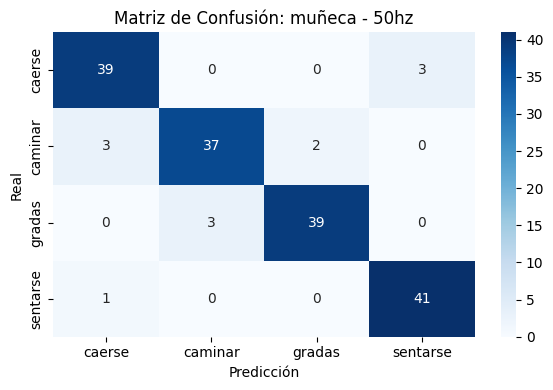

Evaluando grupo: bolsillo - 20hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/rf_modelo_smote_bolsillo__20hz
Tiempo TOTAL de inferencia: 42.296 ms (0.042296 s)
Tiempo PROMEDIO por muestra: 0.2579 ms
RAM pico TOTAL en predict: 62347 bytes (60.885742 KB)
RAM pico por muestra: 380.16 bytes
Tamaño del modelo (.pkl): 924.32 KB
              precision    recall  f1-score   support

      caerse       0.98      0.98      0.98        41
     caminar       0.95      0.85      0.90        41
      gradas       0.88      0.93      0.90        41
    sentarse       0.91      0.95      0.93        41

    accuracy                           0.93       164
   macro avg       0.93      0.93      0.93       164
weighted avg       0.93      0.93      0.93       164



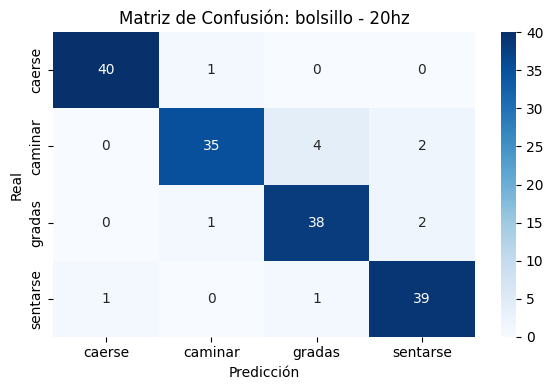

Evaluando grupo: bolsillo - 50hz
Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/rf_modelo_smote_bolsillo__50hz
Tiempo TOTAL de inferencia: 61.139 ms (0.061139 s)
Tiempo PROMEDIO por muestra: 0.4367 ms
RAM pico TOTAL en predict: 53707 bytes (52.448242 KB)
RAM pico por muestra: 383.62 bytes
Tamaño del modelo (.pkl): 821.57 KB
              precision    recall  f1-score   support

      caerse       0.86      0.89      0.87        35
     caminar       0.94      0.91      0.93        35
      gradas       0.89      0.89      0.89        35
    sentarse       0.94      0.94      0.94        35

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



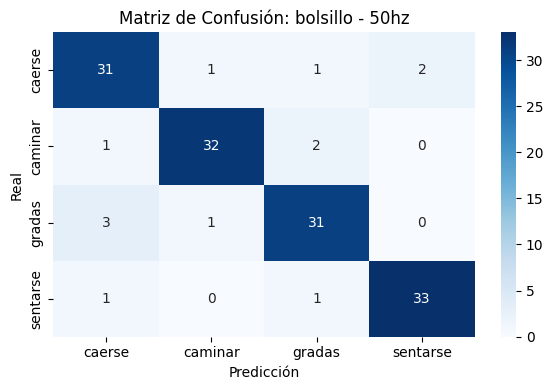

Consumo de recursos Random Forest Balanceado con SMOTE:
             Grupo  Accuracy  Macro_F1   F1_Caer  F1_Caminar  F1_Escaleras  \
0    muñeca - 20hz  0.924779  0.924947  0.904348    0.931034      0.934579   
1    muñeca - 50hz  0.928571  0.928333  0.917647    0.902439      0.939759   
2  bolsillo - 20hz  0.926829  0.926595  0.975610    0.897436      0.904762   
3  bolsillo - 50hz  0.907143  0.907337  0.873239    0.927536      0.885714   

   F1_Sentarse-Pararse  Tiempo total (ms)  Tiempo por muestra (ms)  \
0             0.929825             39.765                   0.1760   
1             0.953488             38.833                   0.2311   
2             0.928571             42.296                   0.2579   
3             0.942857             61.139                   0.4367   

   RAM total (bytes)  RAM por muestra (bytes)  Tamaño modelo (KB)  
0              76755                   339.62             1237.82  
1              63787                   379.68              718.82 

In [11]:
# Lista para guardar resultados de consumo
resultados_rf_smote = []

# Iterar por grupo

# Iterar por grupo
for grupo, archivo in archivos_balanceados_smote.items():
    print(f"Evaluando grupo: {grupo}")
    df = pd.read_csv(archivo)

    # Separar features y etiquetas
    X = df.drop(columns=['etiqueta', 'start_index', 'end_index', 'n_muestras'], errors='ignore')
    y = df['etiqueta']

    # Dividir dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    # Entrenar modelo
    clf_rf_smote = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf_rf_smote.fit(X_train, y_train)
    y_pred = clf_rf_smote.predict(X_test)

    # Ruta donde se guardarán los .PKL
    carpeta_modelos_balanceo_rf_smote = "/content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS"
    os.makedirs(carpeta_modelos_balanceo_rf_smote , exist_ok=True)

    # Evaluar consumo
    nombre_archivo = os.path.join(carpeta_modelos_balanceo_rf_smote , f"rf_modelo_smote_{grupo.replace(' ', '_').replace('-', '')}")
    tiempo_total_ms, tiempo_ms, ram_total_bytes, ram_muestra_bytes, tam_modelo_kb = evaluar_consumo_modelo( clf_rf_smote, X_test, nombre_archivo=nombre_archivo)

    # Guardar resultados
    report = classification_report(y_test, y_pred, output_dict=True)
    resultados_rf_smote.append({
        'Grupo': grupo,
        'Accuracy': report['accuracy'],
        'Macro_F1': report['macro avg']['f1-score'],
        'F1_Caer': report.get('caerse', {}).get('f1-score', 0),
        'F1_Caminar': report.get('caminar', {}).get('f1-score', 0),
        'F1_Escaleras': report.get('gradas', {}).get('f1-score', 0),
        'F1_Sentarse-Pararse': report.get('sentarse', {}).get('f1-score', 0),
        'Tiempo total (ms)': round(tiempo_total_ms, 3),
        'Tiempo por muestra (ms)': round(tiempo_ms, 4),
        'RAM total (bytes)': int(ram_total_bytes),
        'RAM por muestra (bytes)': round(ram_muestra_bytes, 2),
        'Tamaño modelo (KB)': round(tam_modelo_kb, 2)
    })

    # Reporte de clasificación
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=clf_rf_smote.classes_)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clf_rf_smote.classes_, yticklabels=clf_rf_smote.classes_)
    plt.title(f'Matriz de Confusión: {grupo}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

# Convertir resultados a DataFrame
df_resultados_rf_smote = pd.DataFrame(resultados_rf_smote)
print("Consumo de recursos Random Forest Balanceado con SMOTE:")
print(df_resultados_rf_smote)


MODELO 5 --> SVM Balanceado con RandomOverSampler

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/svm_modelo_random_muñeca__20hz
Tiempo TOTAL de inferencia: 15.036 ms (0.015036 s)
Tiempo PROMEDIO por muestra: 0.0665 ms
RAM pico TOTAL en predict: 67720 bytes (66.132812 KB)
RAM pico por muestra: 299.65 bytes
Tamaño del modelo (.pkl): 129.00 KB
Reporte para grupo: muñeca - 20hz
              precision    recall  f1-score   support

      caerse       0.90      0.96      0.93        57
     caminar       0.98      0.91      0.94        56
      gradas       0.98      0.96      0.97        57
    sentarse       0.98      1.00      0.99        56

    accuracy                           0.96       226
   macro avg       0.96      0.96      0.96       226
weighted avg       0.96      0.96      0.96       226



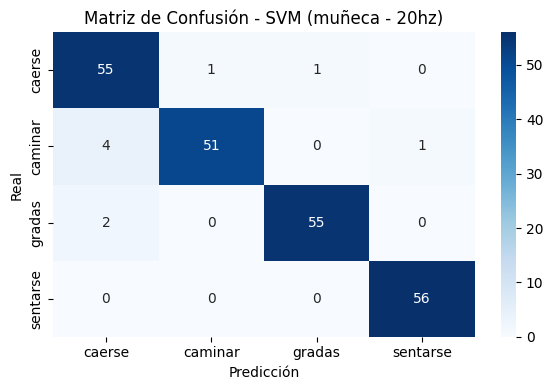

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/svm_modelo_random_muñeca__50hz
Tiempo TOTAL de inferencia: 4.551 ms (0.004551 s)
Tiempo PROMEDIO por muestra: 0.0271 ms
RAM pico TOTAL en predict: 62664 bytes (61.195312 KB)
RAM pico por muestra: 373.00 bytes
Tamaño del modelo (.pkl): 73.50 KB
Reporte para grupo: muñeca - 50hz
              precision    recall  f1-score   support

      caerse       0.97      0.90      0.94        42
     caminar       0.98      0.95      0.96        42
      gradas       0.98      0.98      0.98        42
    sentarse       0.91      1.00      0.95        42

    accuracy                           0.96       168
   macro avg       0.96      0.96      0.96       168
weighted avg       0.96      0.96      0.96       168



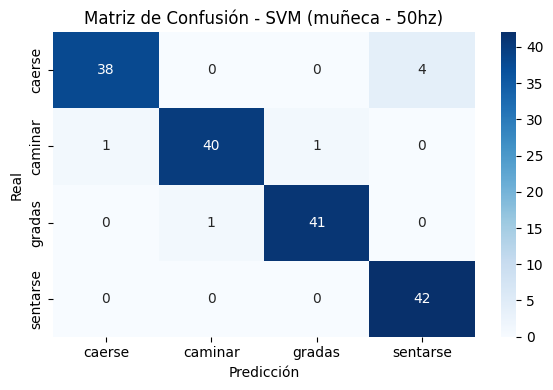

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/svm_modelo_random_bolsillo__20hz
Tiempo TOTAL de inferencia: 5.201 ms (0.005201 s)
Tiempo PROMEDIO por muestra: 0.0317 ms
RAM pico TOTAL en predict: 61224 bytes (59.789062 KB)
RAM pico por muestra: 373.32 bytes
Tamaño del modelo (.pkl): 106.06 KB
Reporte para grupo: bolsillo - 20hz
              precision    recall  f1-score   support

      caerse       0.74      0.98      0.84        41
     caminar       0.97      0.88      0.92        41
      gradas       0.97      0.80      0.88        41
    sentarse       1.00      0.95      0.97        41

    accuracy                           0.90       164
   macro avg       0.92      0.90      0.91       164
weighted avg       0.92      0.90      0.91       164



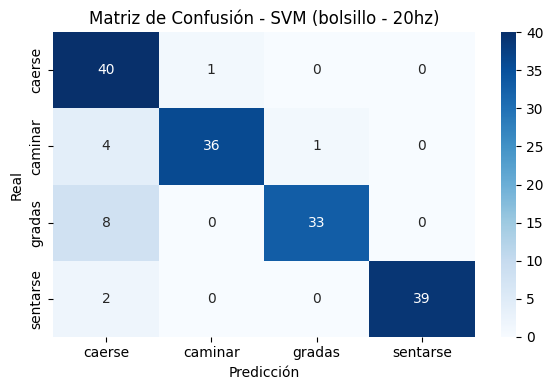

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/svm_modelo_random_bolsillo__50hz
Tiempo TOTAL de inferencia: 3.979 ms (0.003979 s)
Tiempo PROMEDIO por muestra: 0.0284 ms
RAM pico TOTAL en predict: 52584 bytes (51.351562 KB)
RAM pico por muestra: 375.60 bytes
Tamaño del modelo (.pkl): 81.95 KB
Reporte para grupo: bolsillo - 50hz
              precision    recall  f1-score   support

      caerse       0.89      0.91      0.90        35
     caminar       0.92      0.94      0.93        35
      gradas       0.91      0.91      0.91        35
    sentarse       0.94      0.89      0.91        35

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



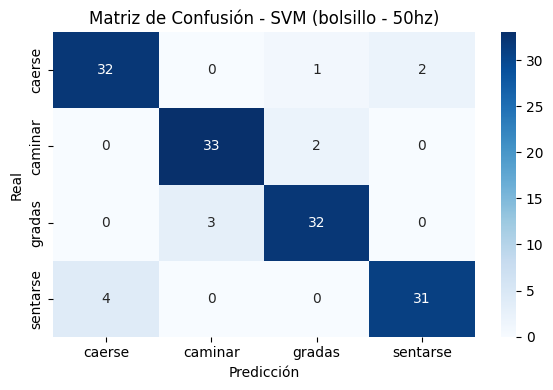

 Resultados resumidos SVM Balanceado con ROS:
             Grupo  Accuracy  Macro_F1   F1_Caer  F1_Caminar  F1_Escaleras  \
0    muñeca - 20hz  0.960177  0.960312  0.932203    0.944444      0.973451   
1    muñeca - 50hz  0.958333  0.958216  0.938272    0.963855      0.976190   
2  bolsillo - 20hz  0.902439  0.905046  0.842105    0.923077      0.880000   
3  bolsillo - 50hz  0.914286  0.914259  0.901408    0.929577      0.914286   

   F1_Sentarse-Pararse  Tiempo total (ms)  Tiempo por muestra (ms)  \
0             0.991150             15.036                   0.0665   
1             0.954545              4.551                   0.0271   
2             0.975000              5.201                   0.0317   
3             0.911765              3.979                   0.0284   

   RAM total (bytes)  RAM por muestra (bytes)  Tamaño modelo (KB)  
0              67720                   299.65              129.00  
1              62664                   373.00               73.50  
2       

In [12]:
# Lista para guardar resultados
resultados_svm_random = []

for grupo, archivo in archivos_balanceados_random.items():
    try:
        df = pd.read_csv(archivo)

        # Separar features y etiquetas
        X = df.drop(columns=['etiqueta', 'start_index', 'end_index', 'n_muestras'], errors='ignore')
        y = df['etiqueta']

        # Escalado de características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)

        # GridSearch para SVM
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.01, 0.1, 1]
        }

        grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=42),
                            param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train, y_train)
        modelo_svm_random = grid.best_estimator_

        # Predicción
        y_pred = modelo_svm_random.predict(X_test)

        # Ruta donde se guardarán los .PKL
        carpeta_modelos_balanceo_svm_random = "/content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS"
        os.makedirs(carpeta_modelos_balanceo_svm_random , exist_ok=True)

        # Evaluar consumo
        nombre_archivo = os.path.join(carpeta_modelos_balanceo_svm_random , f"svm_modelo_random_{grupo.replace(' ', '_').replace('-', '')}")
        tiempo_total_ms, tiempo_ms, ram_total_bytes, ram_muestra_bytes, tam_modelo_kb = evaluar_consumo_modelo(modelo_svm_random, X_test, nombre_archivo=nombre_archivo)


        # Reporte de métricas
        report = classification_report(y_test, y_pred, output_dict=True)
        print(f"Reporte para grupo: {grupo}")
        print(classification_report(y_test, y_pred))

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred, labels=modelo_svm_random.classes_)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=modelo_svm_random.classes_, yticklabels=modelo_svm_random.classes_)
        plt.title(f'Matriz de Confusión - SVM ({grupo})')
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.tight_layout()
        plt.show()

        # Guardar métricas y consumo
        resultados_svm_random.append({
            'Grupo': grupo,
            'Accuracy': report['accuracy'],
            'Macro_F1': report['macro avg']['f1-score'],
            'F1_Caer': report.get('caerse', {}).get('f1-score', 0),
            'F1_Caminar': report.get('caminar', {}).get('f1-score', 0),
            'F1_Escaleras': report.get('gradas', {}).get('f1-score', 0),
            'F1_Sentarse-Pararse': report.get('sentarse', {}).get('f1-score', 0),
            'Tiempo total (ms)': round(tiempo_total_ms, 3),
            'Tiempo por muestra (ms)': round(tiempo_ms, 4),
            'RAM total (bytes)': int(ram_total_bytes),
            'RAM por muestra (bytes)': round(ram_muestra_bytes, 2),
            'Tamaño modelo (KB)': round(tam_modelo_kb, 2)
        })

    except Exception as e:
        print(f"Error con el grupo {grupo}: {e}")
        resultados_svm_random.append({'Grupo': grupo, 'Error': str(e)})

# Mostrar resultados
df_resultados_svm_random = pd.DataFrame(resultados_svm_random)
print(" Resultados resumidos SVM Balanceado con ROS:")
print(df_resultados_svm_random)


MODELO 6 --> SVM Balanceado con SMOTE

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/svm_modelo_smote_muñeca__20hz
Tiempo TOTAL de inferencia: 6.921 ms (0.006921 s)
Tiempo PROMEDIO por muestra: 0.0306 ms
RAM pico TOTAL en predict: 67720 bytes (66.132812 KB)
RAM pico por muestra: 299.65 bytes
Tamaño del modelo (.pkl): 110.53 KB
Reporte para grupo: muñeca - 20hz
              precision    recall  f1-score   support

      caerse       0.94      0.88      0.91        57
     caminar       0.92      0.98      0.95        56
      gradas       0.93      0.89      0.91        57
    sentarse       0.91      0.95      0.93        56

    accuracy                           0.92       226
   macro avg       0.93      0.93      0.92       226
weighted avg       0.93      0.92      0.92       226



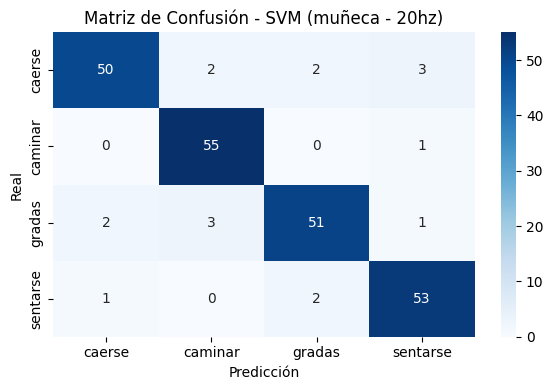

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/svm_modelo_smote_muñeca__50hz
Tiempo TOTAL de inferencia: 3.990 ms (0.003990 s)
Tiempo PROMEDIO por muestra: 0.0237 ms
RAM pico TOTAL en predict: 62664 bytes (61.195312 KB)
RAM pico por muestra: 373.00 bytes
Tamaño del modelo (.pkl): 72.70 KB
Reporte para grupo: muñeca - 50hz
              precision    recall  f1-score   support

      caerse       0.97      0.93      0.95        42
     caminar       0.95      0.98      0.96        42
      gradas       1.00      0.95      0.98        42
    sentarse       0.93      1.00      0.97        42

    accuracy                           0.96       168
   macro avg       0.97      0.96      0.96       168
weighted avg       0.97      0.96      0.96       168



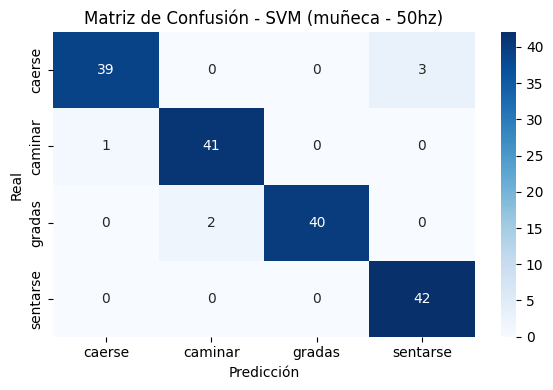

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/svm_modelo_smote_bolsillo__20hz
Tiempo TOTAL de inferencia: 4.873 ms (0.004873 s)
Tiempo PROMEDIO por muestra: 0.0297 ms
RAM pico TOTAL en predict: 61224 bytes (59.789062 KB)
RAM pico por muestra: 373.32 bytes
Tamaño del modelo (.pkl): 89.59 KB
Reporte para grupo: bolsillo - 20hz
              precision    recall  f1-score   support

      caerse       0.90      0.93      0.92        41
     caminar       0.95      0.93      0.94        41
      gradas       0.93      0.90      0.91        41
    sentarse       0.90      0.93      0.92        41

    accuracy                           0.92       164
   macro avg       0.92      0.92      0.92       164
weighted avg       0.92      0.92      0.92       164



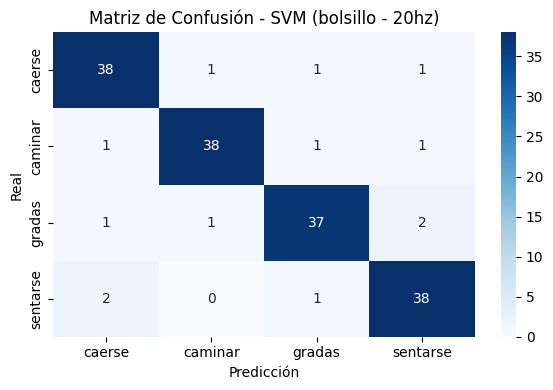

Evaluación del modelo: /content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS/svm_modelo_smote_bolsillo__50hz
Tiempo TOTAL de inferencia: 7.666 ms (0.007666 s)
Tiempo PROMEDIO por muestra: 0.0548 ms
RAM pico TOTAL en predict: 52584 bytes (51.351562 KB)
RAM pico por muestra: 375.60 bytes
Tamaño del modelo (.pkl): 79.94 KB
Reporte para grupo: bolsillo - 50hz
              precision    recall  f1-score   support

      caerse       0.91      0.91      0.91        35
     caminar       0.97      1.00      0.99        35
      gradas       0.97      0.91      0.94        35
    sentarse       0.92      0.94      0.93        35

    accuracy                           0.94       140
   macro avg       0.94      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140



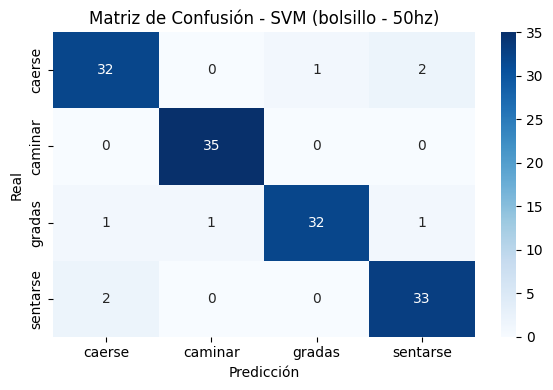

 Resultados resumidos SVM Balanceado con SMOTE:
             Grupo  Accuracy  Macro_F1   F1_Caer  F1_Caminar  F1_Escaleras  \
0    muñeca - 20hz  0.924779  0.924476  0.909091    0.948276      0.910714   
1    muñeca - 50hz  0.964286  0.964263  0.951220    0.964706      0.975610   
2  bolsillo - 20hz  0.920732  0.920794  0.915663    0.938272      0.913580   
3  bolsillo - 50hz  0.942857  0.942739  0.914286    0.985915      0.941176   

   F1_Sentarse-Pararse  Tiempo total (ms)  Tiempo por muestra (ms)  \
0             0.929825              6.921                   0.0306   
1             0.965517              3.990                   0.0237   
2             0.915663              4.873                   0.0297   
3             0.929577              7.666                   0.0548   

   RAM total (bytes)  RAM por muestra (bytes)  Tamaño modelo (KB)  
0              67720                   299.65              110.53  
1              62664                   373.00               72.70  
2     

In [13]:
# Lista para guardar resultados
resultados_svm_smote = []

for grupo, archivo in archivos_balanceados_smote.items():
    try:
        df = pd.read_csv(archivo)

        # Separar features y etiquetas
        X = df.drop(columns=['etiqueta', 'start_index', 'end_index', 'n_muestras'], errors='ignore')
        y = df['etiqueta']

        # Escalado de características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)

        # GridSearch para SVM
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.01, 0.1, 1]
        }

        grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=42),
                            param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train, y_train)
        modelo_svm_smote = grid.best_estimator_

        # Predicción
        y_pred = modelo_svm_smote.predict(X_test)

        # Ruta donde se guardarán los .PKL
        carpeta_modelos_balanceo_svm_smote = "/content/drive/MyDrive/Colab Notebooks/TESIS/FASE OFFLINE/MODELOS_BALANCEADOS"
        os.makedirs(carpeta_modelos_balanceo_svm_smote , exist_ok=True)

        # Evaluar consumo
        nombre_archivo = os.path.join(carpeta_modelos_balanceo_svm_smote , f"svm_modelo_smote_{grupo.replace(' ', '_').replace('-', '')}")
        tiempo_total_ms, tiempo_ms, ram_total_bytes, ram_muestra_bytes, tam_modelo_kb = evaluar_consumo_modelo( modelo_svm_smote, X_test, nombre_archivo=nombre_archivo)

        # Reporte de métricas
        report = classification_report(y_test, y_pred, output_dict=True)
        print(f"Reporte para grupo: {grupo}")
        print(classification_report(y_test, y_pred))

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred, labels=modelo_svm_smote.classes_)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=modelo_svm_smote.classes_, yticklabels=modelo_svm_smote.classes_)
        plt.title(f'Matriz de Confusión - SVM ({grupo})')
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.tight_layout()
        plt.show()

        # Guardar métricas y consumo
        resultados_svm_smote.append({
            'Grupo': grupo,
            'Accuracy': report['accuracy'],
            'Macro_F1': report['macro avg']['f1-score'],
            'F1_Caer': report.get('caerse', {}).get('f1-score', 0),
            'F1_Caminar': report.get('caminar', {}).get('f1-score', 0),
            'F1_Escaleras': report.get('gradas', {}).get('f1-score', 0),
            'F1_Sentarse-Pararse': report.get('sentarse', {}).get('f1-score', 0),
            'Tiempo total (ms)': round(tiempo_total_ms, 3),
            'Tiempo por muestra (ms)': round(tiempo_ms, 4),
            'RAM total (bytes)': int(ram_total_bytes),
            'RAM por muestra (bytes)': round(ram_muestra_bytes, 2),
            'Tamaño modelo (KB)': round(tam_modelo_kb, 2)
        })

    except Exception as e:
        print(f"Error con el grupo {grupo}: {e}")
        resultados_svm_smote.append({'Grupo': grupo, 'Error': str(e)})

# Mostrar resultados
df_resultados_svm_smote = pd.DataFrame(resultados_svm_smote)
print(" Resultados resumidos SVM Balanceado con SMOTE:")
print(df_resultados_svm_smote)

**3.8 EXPORTACIÓN DE RESULTADOS**

In [14]:
df_resultados_rf.to_csv("resultados_rf.csv", index=False)
df_resultados_svm.to_csv("resultados_svm.csv", index=False)
df_resultados_rf_random.to_csv("resultados_rf_random.csv", index=False)
df_resultados_rf_smote.to_csv("resultados_rf_smote.csv", index=False)
df_resultados_svm_random.to_csv("resultados_svm_random.csv", index=False)
df_resultados_svm_smote.to_csv("resultados_svm_smote.csv", index=False)

**3.9 GITHUB**

In [ ]:
import os, subprocess, getpass, datetime, shutil, pathlib

# --- 1) Configuración específica TUYA ---
REPO_URL = "https://github.com/paulam1309/TESIS_Sistema_Recoleccion_Datos_Entrenamiento_Modelo_SL_Clasificaci-n_ADL"
BRANCH   = "main"
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/TESIS"   # carpeta donde están tus cosas
SRC_DIR  = os.path.join(BASE_DIR, "FASE OFFLINE")           # carpeta con tus cambios
REPO_DIR = os.path.join(BASE_DIR, "TESIS_Sistema_Recoleccion_Datos_Entrenamiento_Modelo_SL_Clasificacion_ADL")


def sh(args, cwd=None, check=True):
    print("→", " ".join(args))
    p = subprocess.run(args, cwd=cwd, text=True, capture_output=True)
    if p.stdout: print(p.stdout)
    if p.stderr: print(p.stderr)
    if check and p.returncode != 0:
        raise RuntimeError(f"Fallo cmd: {' '.join(args)}")
    return p

# --- 3) Clonar repo ---
os.makedirs(BASE_DIR, exist_ok=True)
if not os.path.isdir(os.path.join(REPO_DIR, ".git")):
    sh(["git", "clone", REPO_URL, REPO_DIR], cwd=BASE_DIR)
else:
    print(f"✔ Repo ya existe en: {REPO_DIR}")

# --- 4) Configurar git ---
sh(["git", "config", "user.name", "paulam1309"], cwd=REPO_DIR)
sh(["git", "config", "user.email", "paulasofia2015m@gmail.com"], cwd=REPO_DIR)

# --- 5) Autenticación con token ---
token = getpass.getpass("Pega tu GitHub Personal Access Token : ").strip()
# Cambia la URL del remote SOLO para esta sesión
proto_host = REPO_URL.split("://", 1)[-1]  # "github.com/usuario/repo.git"
auth_url = f"https://{token}@{proto_host}"
sh(["git", "remote", "set-url", "origin", auth_url], cwd=REPO_DIR)

# Traer últimos cambios y asegurar rama
sh(["git", "fetch", "origin"], cwd=REPO_DIR)
sh(["git", "checkout", "-B", BRANCH], cwd=REPO_DIR)
sh(["git", "pull", "origin", BRANCH], cwd=REPO_DIR)

# --- 6) Copiar contenido desde FASE OFFLINE al repo ---
if not os.path.isdir(SRC_DIR):
    raise FileNotFoundError(f"No encuentro la carpeta de origen: {SRC_DIR}")

# Copiamos TODO menos la carpeta .git
def copy_tree(src, dst):
    for root, dirs, files in os.walk(src):
        # omitir .git
        if ".git" in dirs:
            dirs.remove(".git")
        rel = os.path.relpath(root, src)
        out_dir = os.path.join(dst, rel) if rel != "." else dst
        os.makedirs(out_dir, exist_ok=True)
        for f in files:
            s = os.path.join(root, f)
            d = os.path.join(out_dir, f)
            shutil.copy2(s, d)

copy_tree(SRC_DIR, REPO_DIR)
print("✔ Copia completada de 'FASE OFFLINE' → repo")

# --- 7) Commit + Push ---
sh(["git", "status"], cwd=REPO_DIR)

# Si no hay cambios, git commit fallará; hacemos commit opcionalmente
msg = "Actualización desde Colab: " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
sh(["git", "add", "."], cwd=REPO_DIR)
commit = sh(["git", "commit", "-m", msg], cwd=REPO_DIR, check=False)
if "nothing to commit" in commit.stdout.lower():
    print("ℹ No hay cambios nuevos para commitear.")
else:
    sh(["git", "push", "origin", BRANCH], cwd=REPO_DIR)

# Restaurar remote limpio (sin token) por higiene
sh(["git", "remote", "set-url", "origin", REPO_URL], cwd=REPO_DIR)

print("✅ Listo. Revisa tu repo en GitHub.")

→ git clone https://github.com/paulam1309/TESIS_Sistema_Recoleccion_Datos_Entrenamiento_Modelo_SL_Clasificaci-n_ADL /content/drive/MyDrive/Colab Notebooks/TESIS/TESIS_Sistema_Recoleccion_Datos_Entrenamiento_Modelo_SL_Clasificacion_ADL
Cloning into '/content/drive/MyDrive/Colab Notebooks/TESIS/TESIS_Sistema_Recoleccion_Datos_Entrenamiento_Modelo_SL_Clasificacion_ADL'...
Updating files:  85% (104/122)
Updating files:  86% (105/122)
Updating files:  87% (107/122)
Updating files:  88% (108/122)
Updating files:  89% (109/122)
Updating files:  90% (110/122)
Updating files:  91% (112/122)
Updating files:  92% (113/122)
Updating files:  93% (114/122)
Updating files:  94% (115/122)
Updating files:  95% (116/122)
Updating files:  96% (118/122)
Updating files:  97% (119/122)
Updating files:  98% (120/122)
Updating files:  99% (121/122)
Updating files: 100% (122/122)
Updating files: 100% (122/122), done.

→ git config user.name paulam1309
→ git config user.email paulasofia2015m@gmail.com
